In [2]:
import subprocess
import argparse
import math
import pandas as pd
from tqdm import tqdm
import pandapower as pp
from pandapower.plotting.plotly import pf_res_plotly
from pandapower.plotting.plotly import simple_plotly
from pandapower.plotting import simple_plot
import time
import numpy as np
import matplotlib.pyplot as plt
import pandapower.networks as nw
from pandapower.plotting import simple_plot, simple_plotly

## Path of IEEE Network Data Files

In [3]:
# Path to the folder with network data
args = {'csv_path': r'../data/network/European_LV_CSV_simplified/'}

In [4]:
args.update({'nb_sub_districts': 5})  #Number of Sub-Districts (Default 1)
args.update({'unbalanced': False}) #Unbalanced or Balanced Network (Default False)
args.update({'draw': False}) #Draw network or not
args.update({'nb_districts': 2}) #Number of Districts (Default 1)

In [5]:
#Initializations of coordinates to draw(plot) the network
h_step = 200
v_step_2 = 200
v_step = v_step_2 * args['nb_sub_districts']

# geodata limits from ELVTF
x_min = 390868.753
y_min = 392747.256

# Import ELVTF dataframes
buses = pd.read_csv(args['csv_path'] + "Buscoords.csv", header=1)
lines = pd.read_csv(args['csv_path'] +"Lines.csv", header=1)
loads = pd.read_csv(args['csv_path'] + "Loads.csv", header=2)

In [6]:
# There battery storage in PandaPower does not include SoC and SoH variables etc. Defining a method to modify the PandaPower storage type to include these variables
# soc_percent = SoC value
# soh_percent = SoH value
# eff_chrg = efficiency charging
# eff_dischrg = efficiency discharging
# n_cycles = total number of cycles of the battery
# dod = depth of discharge
def create_storage_pp(net, name, bus, p_mw=0.0, max_e_mwh=0.03, soc_percent=0.5, soh_percent=0.5, eff_chrg = 0.96, eff_dischrg = 0.95,
                     n_cycles=14000, dod=0.4):
    pp.create_storage(net, bus, p_mw = p_mw, max_e_mwh = max_e_mwh, soc_percent = soc_percent, name = name);
    net.storage['soh_percent'] = soh_percent;
    net.storage['eff_chrg'] = eff_chrg;
    net.storage['eff_dischrg'] = eff_dischrg;
    net.storage['n_cycles'] = n_cycles;
    net.storage['dod'] = dod;

In [7]:
# Defining loads in the network based on the network type.
# If the network is unbalanced, loads are attached based on the phase data
# If the network is balanced, loads are attached without any phase consideration
if args['unbalanced']:
	def create_load_from_row(row):
		P = 0
		S = P / 0.95
		Q = math.sqrt(S**2 - P**2)
		bus = pp.get_element_index(net, "bus","bus_ELVTF_" + str(row["Bus"]) + "_" + str(i) + "_" + str(j))
		if row["phases"] == "A":
			pp.create_asymmetric_load(net, bus=bus, p_a_mw=P, q_a_mvar=Q, name=row["Name"])
		elif row["phases"] == "B":
			pp.create_asymmetric_load(net, bus=bus, p_b_mw=P, q_b_mvar=Q, name=row["Name"])
		elif row["phases"] == "C":
			pp.create_asymmetric_load(net, bus=bus, p_c_mw=P, q_c_mvar=Q, name=row["Name"])
		else:
			print("ERROR: unkown phase")
else: 
	def create_load_from_row(row):
		P = 2 * 1e-3
		S = P / 0.95
		Q = math.sqrt(S**2- P**2)
		pp.create_load(net, bus=pp.get_element_index(net, "bus","bus_ELVTF_" + str(row["Bus"]) + "_" + str(i) + "_" + str(j)),
			p_mw=P, q_mvar=Q, name=row["Name"]+'_'+str(args['nb_sub_districts']*i+j+1))
#		pp.create_sgen(net, bus=pp.get_element_index(net, "bus","bus_ELVTF_" + str(row["Bus"]) + "_" + str(i) + "_" + str(j)),
#			p_mw=0.0011, q_mvar=0, name=row["Name"])
        # Creating EV battery storage at the load buses
		create_storage_pp(net, name="EV" + row["Name"][4:]+'_'+str(args['nb_sub_districts']*i+j+1), bus=pp.get_element_index(net, "bus","bus_ELVTF_" + str(row["Bus"]) + "_" + str(i) + "_" + str(j)),
			p_mw=0.0, max_e_mwh=30.0,soc_percent=0.3, soh_percent=0.9, eff_chrg = 0.96, eff_dischrg = 0.95, n_cycles=14000, dod=0.4 )

In [8]:
# Defining a method to create a line type from the input data
def create_line_type_from_row(row):
	dic = {
	"r_ohm_per_km": row["R1"],
	"x_ohm_per_km": row["X1"],
	"r0_ohm_per_km": row["R0"],
	"x0_ohm_per_km": row["X0"],
	"c_nf_per_km": row["C1"],
	"c0_nf_per_km": row["C0"],
	"max_i_ka": 1 # arbitrary value
	}
	pp.create_std_type(net, dic, row["Name"], element="line")

In [9]:
net = pp.create_empty_network()
# Lines types
# from ELVTF
pd.read_csv(args['csv_path'] + "LineCodes.csv", header=1).apply(create_line_type_from_row, axis=1);

In [10]:
# Creating the required network modeling elements types
dic = {
"c_nf_per_km": 0.14,
"r_ohm_per_km": 0.3891,
"x_ohm_per_km": 0.1507964,
"c0_nf_per_km": 0.147,
"r0_ohm_per_km": 1.5565,
"x0_ohm_per_km": 0.6031856,
"max_i_ka": 1 # arbitrary value
}
pp.create_std_type(net, dic, "N2YSY 1*50rm 18/30 kV it (rated 30 kV)", element="line")

dic = {
    "c_nf_per_km": 0.14,
    "r_ohm_per_km": 0.3891,
    "x_ohm_per_km": 0.1507964,
    "c0_nf_per_km": 0.147,
    "r0_ohm_per_km": 1.5565,
    "x0_ohm_per_km": 0.6031856,
    "max_i_ka": 1 # arbitrary value
}
pp.create_std_type(net, dic, "4c_70", element="line")

dic = {
    "c_nf_per_km": 0.14,
    "r_ohm_per_km": 0.3891,
    "x_ohm_per_km": 0.1507964,
    "c0_nf_per_km": 0.147,
    "r0_ohm_per_km": 1.5565,
    "x0_ohm_per_km": 0.6031856,
    "max_i_ka": 1 # arbitrary value
}
pp.create_std_type(net, dic, "C1", element="line")

dic = {
    "c_nf_per_km": 0.14,
    "r_ohm_per_km": 0.3891,
    "x_ohm_per_km": 0.1507964,
    "c0_nf_per_km": 0.147,
    "r0_ohm_per_km": 1.5565,
    "x0_ohm_per_km": 0.6031856,
    "max_i_ka": 1 # arbitrary value
}
pp.create_std_type(net, dic, "C2", element="line")

dic = {
    "c_nf_per_km": 203.0,
    "r_ohm_per_km": 0.711,
    "x_ohm_per_km": 0.1490001,
    "c0_nf_per_km": 203.0,
    "r0_ohm_per_km": 1.595,
    "x0_ohm_per_km": 0.5550001,
    "max_i_ka": 1 # arbitrary value
}
pp.create_std_type(net, dic, "N2XSY 1*25 10.00 kV", element="line")

dic = {
    "sn_mva": 120,
    "vn_hv_kv": 132.0,
    "vn_lv_kv": 33.0,
    "vk_percent": 13.18,
    "vkr_percent": 0.27764,
    "pfe_kw": 44.9,
    "i0_percent": 0.068,
    "shift_degree": 30,
    "vk0_percent": 10,
    "vkr0_percent": 0,
    # ~ "vector_group": 'YNd',
    "vector_group": 'Dyn',
    "mag0_percent": 100,
    "mag0_rx": 0,
    "si0_hv_partial": 0.9
}
pp.create_std_type(net, dic, "90 MVA 132/33 kV", element="trafo")

dic = {
    "sn_mva": 47,
    "vn_hv_kv": 33,
    "vn_lv_kv": 11,
    "vk_percent": 15,
    "vkr_percent": 0.206383,
    "pfe_kw": 0,
    "i0_percent": 0,
    "shift_degree": 0,
    "vk0_percent": 11,
    "vkr0_percent": 0,
    "vector_group": 'YNyn',
    "mag0_percent": 100,
    "mag0_rx": 0,
    "si0_hv_partial": 0.9
}
pp.create_std_type(net, dic, "47 MVA 33/11 kV", element="trafo")

dic = {
    "sn_mva": 0.8,
    "vn_hv_kv": 11,
    "vn_lv_kv": 0.416,
    "vk_percent": 4.01995,
    "vkr_percent": 0.4,
    "pfe_kw": 0,
    "i0_percent": 0,
    "shift_degree": 180,
    "vk0_percent": 6,
    "vkr0_percent": 1.30,
    "vector_group": 'Yyn',
    "mag0_percent": 100,
    "mag0_rx": 0,
    "si0_hv_partial": 0.9
}
pp.create_std_type(net, dic, "ELVTF", element="trafo")

In [11]:
# Connection to the external grid
pp.create_bus(net, vn_kv=132, name="bus_ext", geodata=(0,0))
pp.create_ext_grid(net, 
	bus=pp.get_element_index(net, "bus","bus_ext"), vm_pu=1.05,
	name="Grid_Connection", s_sc_max_mva=2286,
	rx_max=0.09, x0x_max=1.0, r0x0_max=0.09)

0

In [12]:
if args['unbalanced']:
	# Transformer T0
	pp.create_bus(net, vn_kv=33, name="bus_transfo_0", geodata=(2 * h_step,0))
	pp.create_transformer(net, 
		hv_bus=pp.get_element_index(net, "bus","bus_ext"), 
		lv_bus=pp.get_element_index(net, "bus","bus_transfo_0"), 
		std_type="90 MVA 132/33 kV")
else:
	# Impedance of the external grid R0
	pp.create_bus(net, vn_kv=132, name="bus_imp_0", geodata=(h_step,0))
	pp.create_impedance(net,
		from_bus=pp.get_element_index(net, "bus","bus_ext"), 
		to_bus=pp.get_element_index(net, "bus","bus_imp_0"), 
		rft_pu=0.66/17424, xft_pu=7.57/17424, sn_mva=1000)
	# Transformer T0
	pp.create_bus(net, vn_kv=33, name="bus_transfo_0", geodata=(2 * h_step,0))
#	pp.create_line(net, name = "132_33 Line",length_km=0.02, from_bus=pp.get_element_index(net, "bus","bus_ext"), to_bus=pp.get_element_index(net, "bus","bus_transfo_0"), std_type="4c_70")
	pp.create_transformer(net, 
		hv_bus=pp.get_element_index(net, "bus","bus_imp_0"), 
		lv_bus=pp.get_element_index(net, "bus","bus_transfo_0"), 
		std_type="90 MVA 132/33 kV",name= "trafo 132/33")

In [13]:
# First Network Division
for i in tqdm(range(0, args['nb_districts'])):
	# Lines R1
	#Transformers T1
	pp.create_bus(net, vn_kv=11, name=("bus_transfo_T1_" + str(i)),
		geodata=(4 * h_step, v_step * i))
	pp.create_transformer(net, 
		hv_bus=pp.get_element_index(net, "bus","bus_transfo_0"),
		lv_bus=pp.get_element_index(net, "bus","bus_transfo_T1_" + str(i)),
		std_type="47 MVA 33/11 kV", name= "trafo 33/11" +'_'+ str(i+1))
	# Second Network division
	for j in range(0, args['nb_sub_districts']):
		# Buses ELVTF
		buses.apply(lambda row:
			pp.create_bus(net, 0.416, 
				name="bus_ELVTF_" + str(int(row["Busname"])) + "_" + str(i) + "_" + str(j),
				geodata=(7 * h_step + row[" x"] - x_min, v_step * i + v_step_2 * j + row[" y"] - y_min)), axis=1)
		#Transformers T2
		pp.create_transformer(net, 
			hv_bus = pp.get_element_index(net, "bus","bus_transfo_T1_" + str(i)),
			lv_bus=pp.get_element_index(net, "bus","bus_ELVTF_1_"  + str(i) + "_" + str(j)),
			std_type='ELVTF',name="trafo ELVTF" + '_'+str(args['nb_sub_districts']*i+j+1))
		# Lines ELVTF
		lines.apply(lambda row:
			pp.create_line(net, 
				from_bus=pp.get_element_index(net, "bus","bus_ELVTF_" + str(row["Bus1"]) + "_" + str(i) + "_" + str(j)),
				to_bus=pp.get_element_index(net, "bus","bus_ELVTF_" + str(row["Bus2"]) + "_" + str(i) + "_" + str(j)),
				length_km=row["Length"]/1000.0, std_type=row["LineCode"], name=row["Name"]), axis=1)
		# Loads ELVTF
		loads.apply(create_load_from_row, axis=1)

100%|██████████| 2/2 [00:13<00:00,  6.54s/it]


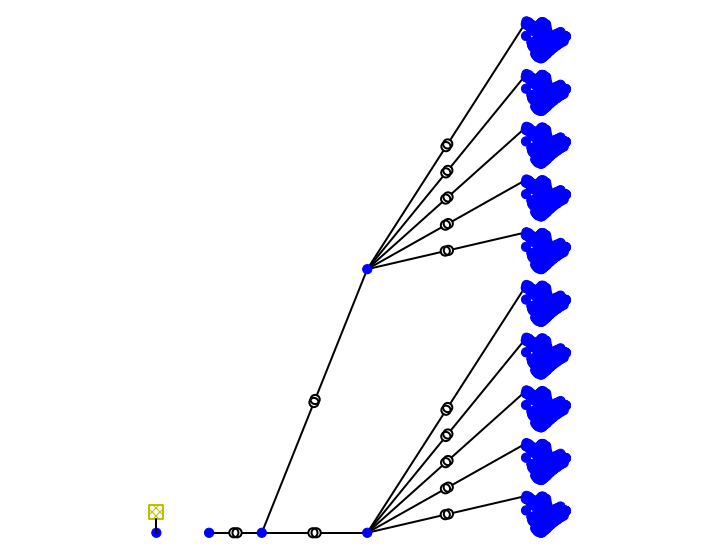

In [14]:
# Making a simple plot of the network
simple_plot(net, scale_size=True, ext_grid_size=1.0, trafo_size=1.0, bus_size=1.0);

In [15]:
# Customized run power flow method to incorporate customized battery storage method earlier
def runpp_pp(net, time_step = 1):
    # Running power flow
    pp.runpp(net);
    net.res_storage['soc_percent'] = 0.0000001;
    net.res_storage['soh_percent'] = 0.0000001;
    # Update SoC and SoH of each storage
    for i in range(0,len(net.storage)):
        soc_f = net.storage['soc_percent'][i] + ((((net.storage['p_mw'][i])*(time_step/3600)*net.storage['eff_chrg'][i])/net.storage['max_e_mwh'][i]) if (net.storage['p_mw'][i]>0) else (((net.storage['p_mw'][i])*(time_step/3600))/(net.storage['max_e_mwh'][i]*net.storage['eff_dischrg'][i])))
        soh_f = net.storage['soh_percent'][i] + (0 if (net.storage['p_mw'][i]>0) else (((net.storage['p_mw'][i])*(time_step/3600))/(0.2*net.storage['max_e_mwh'][i]*net.storage['eff_dischrg'][i]*net.storage['n_cycles'][i]*net.storage['dod'][i])))
        soc_f = min(max(0,soc_f),1)
        soh_f = min(max(0,soh_f),1)
        net.res_storage['soc_percent'].at[i] = soc_f;
        net.res_storage['soh_percent'].at[i] = soh_f;

# Assigning SoC and SoH results of this time step as the input of the next time step
def update_states(net):
    for i in range(0,len(net.storage)):
        net.storage['soc_percent'].at[i] = net.res_storage['soc_percent'][i]
        net.storage['soh_percent'].at[i] = net.res_storage['soh_percent'][i]